# Processing

In [2]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [3]:
import os
import time
import random
import numpy as np
import cv2
import torch

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Augmentation

In [4]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    size = (256, 256)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    data_path = "/kaggle/input/drive2004/DRIVE"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Create directories to save the augmented data """
    create_dir("new_data/train/image/")
    create_dir("new_data/train/mask/")
    create_dir("new_data/test/image/")
    create_dir("new_data/test/mask/")

    """ Data augmentation """
    augment_data(train_x, train_y, "new_data/train/", augment=True)
    augment_data(test_x, test_y, "new_data/test/", augment=False)

Train: 20 - 20
Test: 20 - 20


100%|██████████| 20/20 [00:00<00:00, 23.13it/s]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)


class DeconvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.deconv = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        return self.deconv(x)


class UNETR_2D(nn.Module):
    def __init__(self, cf):
        super().__init__()
        self.cf = cf

        """ Patch + Position Embeddings """
        self.patch_embed = nn.Linear(
            cf["patch_size"] * cf["patch_size"] * cf["num_channels"], cf["hidden_dim"]
        )
        self.positions = torch.arange(start=0, end=cf["num_patches"], step=1, dtype=torch.int64)
        self.pos_embed = nn.Embedding(cf["num_patches"], cf["hidden_dim"])

        """ Transformer Encoder """
        self.trans_encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=cf["hidden_dim"],
                nhead=cf["num_heads"],
                dim_feedforward=cf["mlp_dim"],
                dropout=cf["dropout_rate"],
                activation=nn.GELU(),
                batch_first=True
            ) for _ in range(cf["num_layers"])
        ])

        """ CNN Decoder """
        ## Decoder 1
        self.d1 = DeconvBlock(cf["hidden_dim"], 512)
        self.s1 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 512),
            ConvBlock(512, 512)
        )
        self.c1 = nn.Sequential(
            ConvBlock(512 + 512, 512),
            ConvBlock(512, 512)
        )

        ## Decoder 2
        self.d2 = DeconvBlock(512, 256)
        self.s2 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 256),
            ConvBlock(256, 256),
            DeconvBlock(256, 256),
            ConvBlock(256, 256)
        )
        self.c2 = nn.Sequential(
            ConvBlock(256 + 256, 256),
            ConvBlock(256, 256)
        )

        ## Decoder 3
        self.d3 = DeconvBlock(256, 128)
        self.s3 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 128),
            ConvBlock(128, 128),
            DeconvBlock(128, 128),
            ConvBlock(128, 128),
            DeconvBlock(128, 128),
            ConvBlock(128, 128)
        )
        self.c3 = nn.Sequential(
            ConvBlock(128 + 128, 128),
            ConvBlock(128, 128)
        )

        ## Decoder 4
        self.d4 = DeconvBlock(128, 64)
        self.s4 = nn.Sequential(
            ConvBlock(3, 64),
            ConvBlock(64, 64)
        )
        self.c4 = nn.Sequential(
            ConvBlock(64 + 64, 64),
            ConvBlock(64, 64)
        )

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        #print("Input Image Shape:", inputs.shape)

        """ Patch + Position Embeddings """
        batch = inputs.shape[0]
        patches = F.unfold(inputs, kernel_size=self.cf["patch_size"], stride=self.cf["patch_size"])
        patches = patches.transpose(1, 2).reshape(batch, -1, self.cf["patch_size"] * self.cf["patch_size"] * self.cf["num_channels"])
        patch_embed = self.patch_embed(patches)
        positions = self.positions.to(inputs.device)
        pos_embed = self.pos_embed(positions)
        x = patch_embed + pos_embed
        #print("Patch + Position Embeddings Shape:", x.shape)

        """ Transformer Encoder """
        skip_connection_index = [3, 6, 9, 12]
        skip_connections = []

        for i in range(self.cf["num_layers"]):
            layer = self.trans_encoder_layers[i]
            x = layer(x)
            if (i + 1) in skip_connection_index:
                skip_connections.append(x)
        #print("After Transformer Encoder Shape:", x.shape)

        """ CNN Decoder """
        z3, z6, z9, z12 = skip_connections

        ## Reshaping
        z0 = inputs
        shape = (batch, self.cf["hidden_dim"], self.cf["patch_size"], self.cf["patch_size"])
        z3 = z3.view(shape)
        z6 = z6.view(shape)
        z9 = z9.view(shape)
        z12 = z12.view(shape)

        ## Decoder 1
        x = self.d1(z12)
        #print("After Decoder 1 DeconvBlock Shape:", x.shape)
        s = self.s1(z9)
        x = torch.cat([x, s], dim=1)
        x = self.c1(x)
        #print("After Decoder 1 ConvBlock Shape:", x.shape)

        ## Decoder 2
        x = self.d2(x)
        #print("After Decoder 2 DeconvBlock Shape:", x.shape)
        s = self.s2(z6)
        x = torch.cat([x, s], dim=1)
        x = self.c2(x)
        #print("After Decoder 2 ConvBlock Shape:", x.shape)

        ## Decoder 3
        x = self.d3(x)
        #print("After Decoder 3 DeconvBlock Shape:", x.shape)
        s = self.s3(z3)
        x = torch.cat([x, s], dim=1)
        x = self.c3(x)
        #print("After Decoder 3 ConvBlock Shape:", x.shape)

        ## Decoder 4
        x = self.d4(x)
        #print("After Decoder 4 DeconvBlock Shape:", x.shape)
        s = self.s4(z0)
        x = torch.cat([x, s], dim=1)
        x = self.c4(x)
        #print("After Decoder 4 ConvBlock Shape:", x.shape)

        """ Output """
        output = self.output(x)
        #print("Final Output Shape:", output.shape)

        return output


if __name__ == "__main__":
    config = {
        "image_size": 256,
        "num_layers": 12,
        "hidden_dim": 256,
        "mlp_dim": 1536,
        "num_heads": 8,
        "dropout_rate": 0.1,
        "num_patches": 256,
        "patch_size": 16,
        "num_channels": 3
    }

    model = UNETR_2D(config)
    print(model)

UNETR_2D(
  (patch_embed): Linear(in_features=768, out_features=256, bias=True)
  (pos_embed): Embedding(256, 256)
  (trans_encoder_layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=1536, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1536, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (activation): GELU(approximate='none')
    )
  )
  (d1): DeconvBlock(
    (deconv): ConvTranspose2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
  )
  (s1): Sequential(
    (0): DeconvBlock(
      (deconv): ConvTranspose2d(256, 512

# Metrics

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

def calculate_accuracy(outputs, masks):
    predicted = outputs > 0.5  # Assuming binary classification
    correct = (predicted == masks.byte()).float()  # Convert masks to byte tensor for comparison
    accuracy = correct.sum() / torch.numel(masks)
    return accuracy.item()

def calculate_dice_coefficient(outputs, masks):
    smooth = 1e-6  # Smoothing factor to avoid division by zero
    predicted = outputs > 0.5  # Assuming binary classification
    intersection = (predicted & masks.byte()).float().sum()
    union = predicted.float().sum() + masks.float().sum()
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    return dice_coefficient.item()

# Train

In [17]:
import torch
import time
from torch.utils.data import DataLoader
from glob import glob
import matplotlib.pyplot as plt

def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_dice = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        dice = calculate_dice_coefficient(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_dice += dice

    epoch_loss = epoch_loss / len(loader)
    epoch_acc = epoch_acc / len(loader)
    epoch_dice = epoch_dice / len(loader)
    return epoch_loss, epoch_acc, epoch_dice

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_dice = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            dice = calculate_dice_coefficient(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc
            epoch_dice += dice

        epoch_loss = epoch_loss / len(loader)
        epoch_acc = epoch_acc / len(loader)
        epoch_dice = epoch_dice / len(loader)
    return epoch_loss, epoch_acc, epoch_dice

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Load dataset """
    train_x = sorted(glob("/kaggle/working/new_data/train/image/**/*.png", recursive=True))
    train_y = sorted(glob("/kaggle/working/new_data/train/mask/**/*.png", recursive=True))

    valid_x = sorted(glob("/kaggle/working/new_data/test/image/**/*.png", recursive=True))
    valid_y = sorted(glob("/kaggle/working/new_data/test/mask/**/*.png", recursive=True))

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 256
    W = 256
    size = (H, W)
    batch_size = 2
    num_epochs = 100
    lr = 1e-4
    checkpoint_path = "files/checkpoint.pth"

    """ Dataset and loader """
    train_dataset = DriveDataset(train_x, train_y)
    valid_dataset = DriveDataset(valid_x, valid_y)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=3
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=3
    )

    device = torch.device('cuda')   ## GTX 1060 6GB
    model = UNETR_2D(config)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()

    """ Training the model """
    best_valid_loss = float("inf")

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_dice = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_acc, valid_dice = evaluate(model, valid_loader, loss_fn, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        """ Saving the model """
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | Train Dice: {train_dice:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc:.3f} | Val. Dice: {valid_dice:.3f}\n'
        print(data_str)

Dataset Size:
Train: 80 - Valid: 20

Valid loss improved from inf to 1.4092. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.407 | Train Acc: 0.893 | Train Dice: 0.349
	 Val. Loss: 1.409 | Val. Acc: 0.941 | Val. Dice: 0.063

Valid loss improved from 1.4092 to 1.1459. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 1.201 | Train Acc: 0.931 | Train Dice: 0.456
	 Val. Loss: 1.146 | Val. Acc: 0.934 | Val. Dice: 0.477

Valid loss improved from 1.1459 to 1.0804. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 1.117 | Train Acc: 0.935 | Train Dice: 0.477
	 Val. Loss: 1.080 | Val. Acc: 0.939 | Val. Dice: 0.487

Valid loss improved from 1.0804 to 1.0315. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 1.067 | Train Acc: 0.940 | Train Dice: 0.491
	 Val. Loss: 1.031 | Val. Acc: 0.944 | Val. Dice: 0.509

Valid loss improved from 1.0315 to 1.0058. Saving chec

# Test

In [18]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
'''
from model import build_unet
from utils import create_dir, seeding
'''
def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("/kaggle/working/new_data/test/image/*"))
    test_y = sorted(glob("/kaggle/working/new_data/test/mask/*"))

    """ Hyperparameters """
    H = 256
    W = 256
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = UNETR_2D(config)
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)

100%|██████████| 20/20 [00:02<00:00,  7.57it/s]

Jaccard: 0.5657 - F1: 0.7215 - Recall: 0.6892 - Precision: 0.7740 - Acc: 0.9542
FPS:  124.76066962532867


# Predict Image

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image, mask, output):
    """
    Display the input image, ground truth mask, and predicted mask
    """
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    # Plot input image
    input_image_bgr = np.transpose(image.squeeze().cpu().detach().numpy(), (1, 2, 0))[:, :, ::-1]  # RGB to BGR
    
    # Plot input image
    axs[0].imshow(input_image_bgr)
    axs[0].set_title('Input Image (BGR)')
    axs[0].axis('off')
    
    # Plot ground truth mask
    axs[1].imshow(mask.squeeze().cpu().detach().numpy(), cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')
    
    # Plot predicted mask
    # Plot predicted mask
    axs[2].imshow(output.squeeze().cpu().detach().numpy(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    
    plt.show()

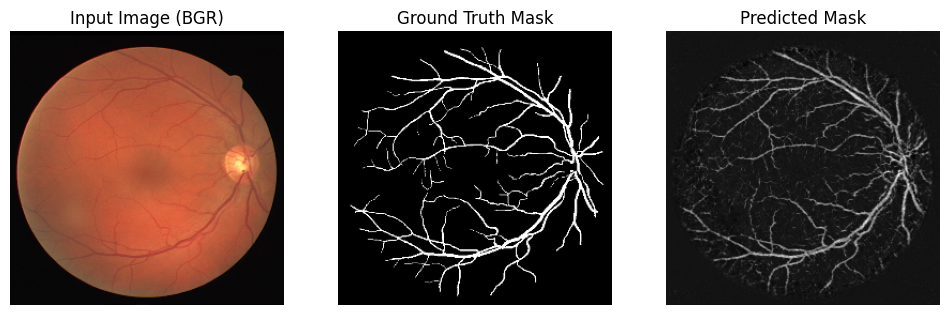

In [20]:
# Assuming you have an image, ground truth mask, and predicted mask tensors
image = x[0]  # Example image from the dataset
mask = y[0]    # Corresponding ground truth mask
output = model(image.unsqueeze(0).to(device))  # Model prediction for the image

# Display the images
display_image(image, mask, output)

# Graphs

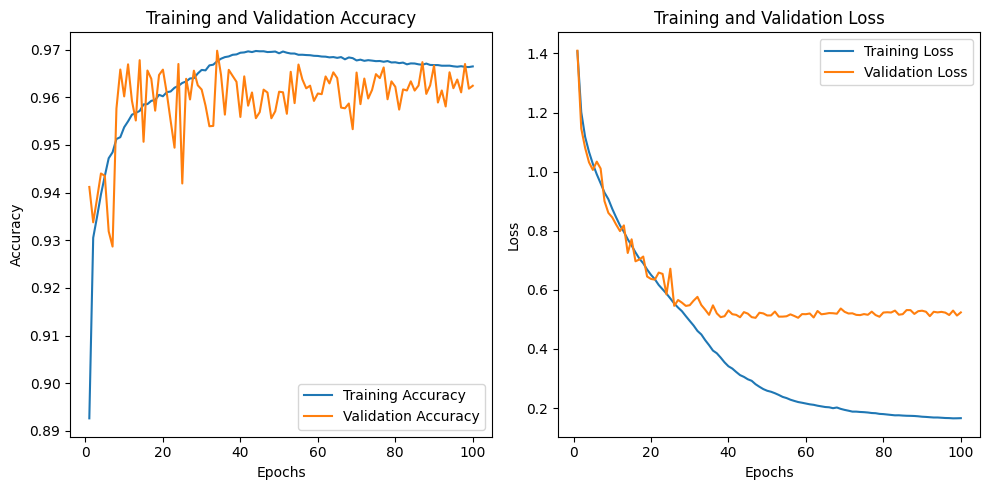

In [24]:
import torch
import time
from torch.utils.data import DataLoader
from glob import glob
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()